In [2]:
import numpy as np
import pandas as pd

from xgboost import XGBClassifier


from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

import pickle

In [3]:
df_original = pd.read_csv('../datasets/Churn_Modelling.csv')
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
churn_df = df_original.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender'],
                            axis=1)
churn_df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


In [5]:
churn_df2 = pd.get_dummies(churn_df, drop_first='True')
churn_df2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True


In [6]:
y = churn_df2["Exited"]

X = churn_df2.copy()
X = X.drop("Exited", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [7]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

cv_params = {'max_depth': [4,5,6,7,8],
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 125]
             }

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

In [17]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 2min 41s, sys: 3min 43s, total: 6min 25s
Wall time: 3min


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.1, 0.2, ...], 'max_depth': [4, 5, ...], 'min_child_weight': [1, 2, ...], 'n_estimators': [75, 100, ...]}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,None
,refit,'f1'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [14]:
path = "../models/"
with open(path + 'xgb_cv_model.pickle', 'wb') as to_write:
    pickle.dump(xgb_cv, to_write)

In [18]:
with open(path+'xgb_cv_model.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read)

In [16]:
with open(path+'rf_cv_model.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

rf_cv.fit(X_train, y_train)

,estimator,RandomForestC...andom_state=0)
,param_grid,"{'max_depth': [2, 3, ...], 'max_features': [2, 3, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 3, ...], ...}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,None
,refit,'f1'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,150


In [19]:
print('F1 score random forest CV: ', rf_cv.best_score_)
print('F1 score XGB CV: ', xgb_cv.best_score_)

F1 score random forest CV:  0.5833023473561427
F1 score XGB CV:  0.5815449412084907


In [20]:
def make_results(model_name, model_object):

    cv_results = pd.DataFrame(model_object.cv_results_)


    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy]
                         }
                        )

    return table

In [21]:
xgb_cv_results = make_results('XGBoost CV', xgb_cv)
xgb_cv_results

,Model,F1,Recall,Precision,Accuracy
0,XGBoost CV,0.581545,0.474491,0.755036,0.8612


In [22]:
xgb_cv_preds = xgb_cv.predict(X_test)
print('F1 score final XGB model: ', f1_score(y_test, xgb_cv_preds))
print('Recall score final XGB model: ', recall_score(y_test, xgb_cv_preds))
print('Precision score final XGB model: ', precision_score(y_test, xgb_cv_preds))
print('Accuracy score final XGB model: ', accuracy_score(y_test, xgb_cv_preds))

F1 score final XGB model:  0.6059880239520958
Recall score final XGB model:  0.49705304518664045
Precision score final XGB model:  0.7760736196319018
Accuracy score final XGB model:  0.8684


In [23]:
def conf_matrix_plot(model, x_data, y_data):

    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)

    disp.plot()
    plt.show()

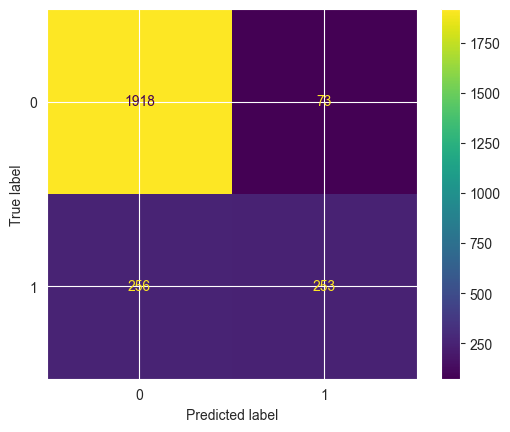

In [24]:
conf_matrix_plot(xgb_cv, X_test, y_test)

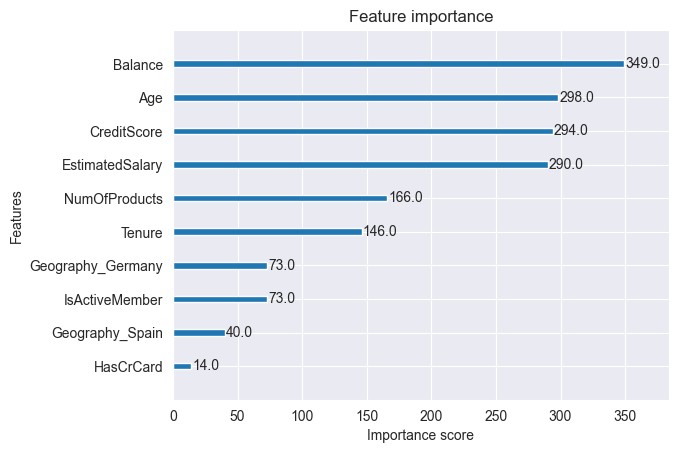

In [25]:
plot_importance(xgb_cv.best_estimator_);